### **Importing necessary dependencies**

In [1]:
import datetime as dt
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
# %matplotlib inline
import numpy as np
import pandas as pd
from random import choice, randint
import scipy.stats as scs
import seaborn as sns
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils.validation import check_is_fitted
from statsmodels.tsa.stattools import adfuller
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import warnings
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from statsmodels.graphics.tsaplots import plot_acf

### **Loading the data**

In [2]:
data = pd.read_csv(filepath_or_buffer="interstate_traffic.csv", sep=",")
data.shape

(48204, 9)

In [3]:
data.head(5)

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,NaN,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,NaN,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,NaN,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,NaN,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,NaN,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


### **Renaming columns**

In [4]:
data.rename(
    columns={
        "rain_1h": "rain",
        "snow_1h": "snow",
        "clouds_all": "cloud",
        "weather_main": "weather",
        "traffic_volume": "traffic"
    },
    inplace=True
)

In [5]:
data.head(5)

,holiday,temp,rain,snow,cloud,weather,weather_description,date_time,traffic
0,NaN,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,NaN,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,NaN,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,NaN,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,NaN,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


### **Checking for null values**

In [6]:
data.isnull().sum()

,0
holiday,48143
temp,0
rain,0
snow,0
cloud,0
weather,0
weather_description,0
date_time,0
traffic,0


### **Dropping the holiday column as it is entirely sparse**

In [7]:
data.drop('holiday', inplace = True, axis = 1)

In [8]:
data.head(5)

,temp,rain,snow,cloud,weather,weather_description,date_time,traffic
0,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


### **Encoding the categorical variables**

In [9]:
# encoding the weather and weather_description variables that are categorical in nature
label_encoder = LabelEncoder()
data['weather'] = label_encoder.fit_transform(data['weather'])
data['weather_description'] = label_encoder.fit_transform(data['weather_description'])

In [10]:
data.head(5)

,temp,rain,snow,cloud,weather,weather_description,date_time,traffic
0,288.28,0.0,0.0,40,1,24,2012-10-02 09:00:00,5545
1,289.36,0.0,0.0,75,1,2,2012-10-02 10:00:00,4516
2,289.58,0.0,0.0,90,1,19,2012-10-02 11:00:00,4767
3,290.13,0.0,0.0,90,1,19,2012-10-02 12:00:00,5026
4,291.14,0.0,0.0,75,1,2,2012-10-02 13:00:00,4918


### **Plotting the correlation between all the variables**

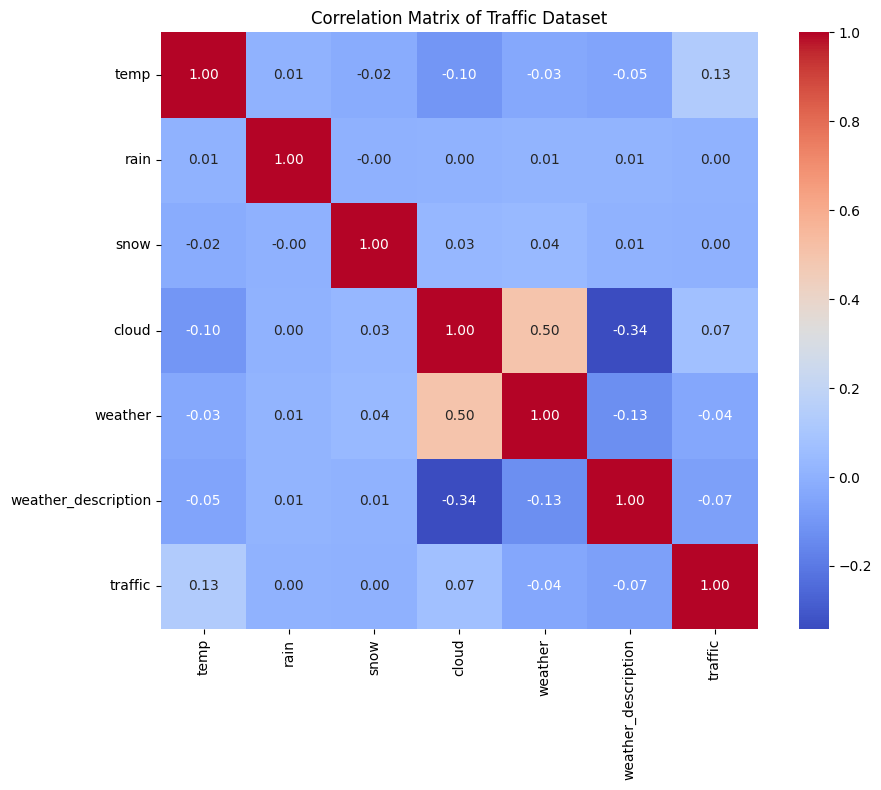

In [11]:
corr_matrix = data.corr(numeric_only=True)
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Matrix of Traffic Dataset")
plt.tight_layout()
plt.show()

### **As we can see there is very little correlation between traffic and all the other variables**

### **Hence we perform PCA**

In [12]:
data.head(5)

,temp,rain,snow,cloud,weather,weather_description,date_time,traffic
0,288.28,0.0,0.0,40,1,24,2012-10-02 09:00:00,5545
1,289.36,0.0,0.0,75,1,2,2012-10-02 10:00:00,4516
2,289.58,0.0,0.0,90,1,19,2012-10-02 11:00:00,4767
3,290.13,0.0,0.0,90,1,19,2012-10-02 12:00:00,5026
4,291.14,0.0,0.0,75,1,2,2012-10-02 13:00:00,4918


In [13]:
features = ['temp', 'rain', 'snow', 'cloud', 'weather', 'weather_description']
X = data[features]

### **Scaling the values (necessary for PCA)**

In [14]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

### **Creating two new components**

In [15]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

In [16]:
pca_df = pd.DataFrame(X_pca, columns=['PCA1', 'PCA2'])
pca_df['traffic'] = data['traffic'].values

### **Plotting the components**

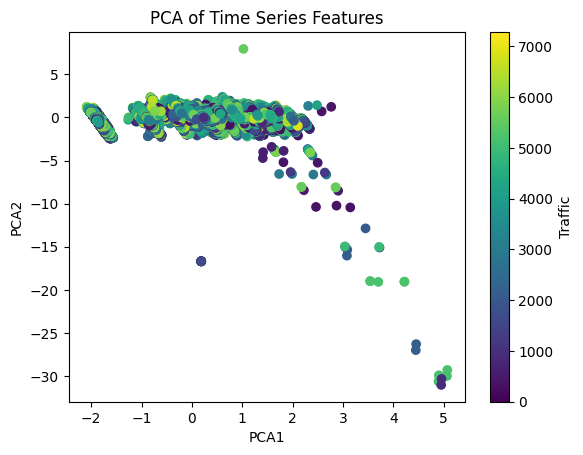

In [17]:
plt.scatter(pca_df['PCA1'], pca_df['PCA2'], c=pca_df['traffic'], cmap='viridis')
plt.colorbar(label='Traffic')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title('PCA of Time Series Features')
plt.show()

### **Checking the correlation b/w the principle components and traffic**


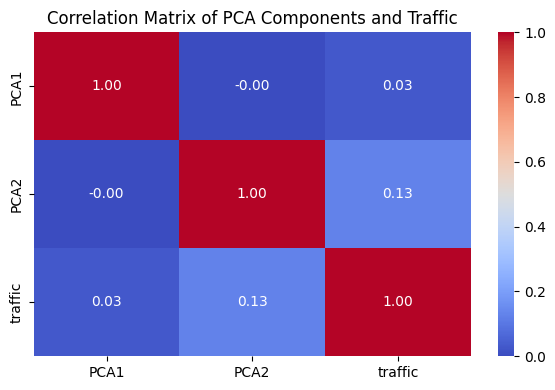

In [18]:
corr_matrix = pca_df.corr()
plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of PCA Components and Traffic")
plt.tight_layout()
plt.show()

### **Since the correlation between the principle components and traffic is not that high, autoregression is the best option available**

In [19]:
data.head(5)

,temp,rain,snow,cloud,weather,weather_description,date_time,traffic
0,288.28,0.0,0.0,40,1,24,2012-10-02 09:00:00,5545
1,289.36,0.0,0.0,75,1,2,2012-10-02 10:00:00,4516
2,289.58,0.0,0.0,90,1,19,2012-10-02 11:00:00,4767
3,290.13,0.0,0.0,90,1,19,2012-10-02 12:00:00,5026
4,291.14,0.0,0.0,75,1,2,2012-10-02 13:00:00,4918


In [20]:
auto_reg_data = data[['date_time', 'traffic']]
auto_reg_data

,date_time,traffic
0,2012-10-02 09:00:00,5545
1,2012-10-02 10:00:00,4516
2,2012-10-02 11:00:00,4767
3,2012-10-02 12:00:00,5026
4,2012-10-02 13:00:00,4918
...,...,...
48199,2018-09-30 19:00:00,3543
48200,2018-09-30 20:00:00,2781
48201,2018-09-30 21:00:00,2159
48202,2018-09-30 22:00:00,1450


Text(0.5, 1.0, 'Distribution of Traffic Volume')

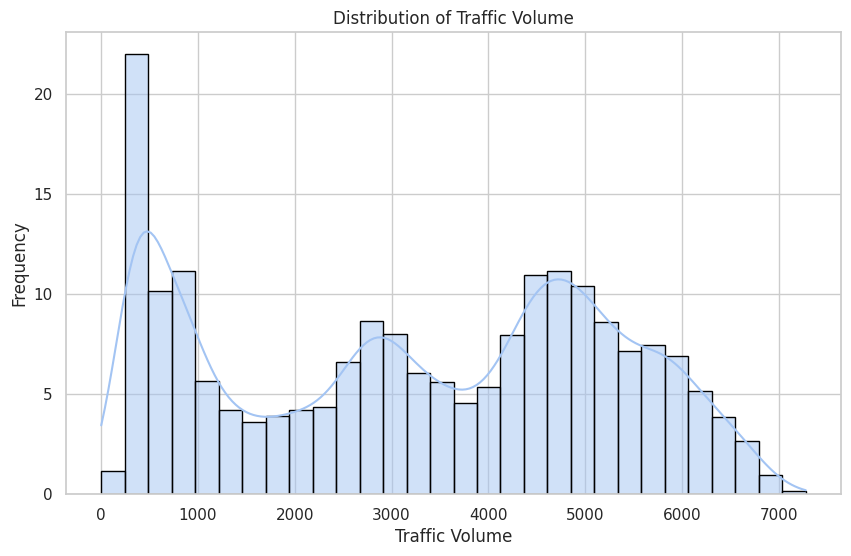

In [21]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.histplot(data=auto_reg_data, x='traffic', kde=True, stat='frequency', bins=30, color='#A3C4F3', edgecolor='black')
plt.xlabel('Traffic Volume')
plt.ylabel('Frequency')
plt.title('Distribution of Traffic Volume')

In [22]:
auto_reg_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   date_time  48204 non-null  object
 1   traffic    48204 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 753.3+ KB


### **Converting the date time column into the proper format and setting it as the index**

In [23]:
auto_reg_data['date_time'] = pd.to_datetime(auto_reg_data['date_time'])
auto_reg_data.set_index('date_time', inplace=True)

<ipython-input-23-afeb797ae95f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  auto_reg_data['date_time'] = pd.to_datetime(auto_reg_data['date_time'])


In [24]:
auto_reg_data.head(5)

,traffic
date_time,
2012-10-02 09:00:00,5545
2012-10-02 10:00:00,4516
2012-10-02 11:00:00,4767
2012-10-02 12:00:00,5026
2012-10-02 13:00:00,4918


In [25]:
auto_reg_data.shape

(48204, 1)

### **Plotting the autocorrelation matrix**

<Figure size 1000x600 with 0 Axes>

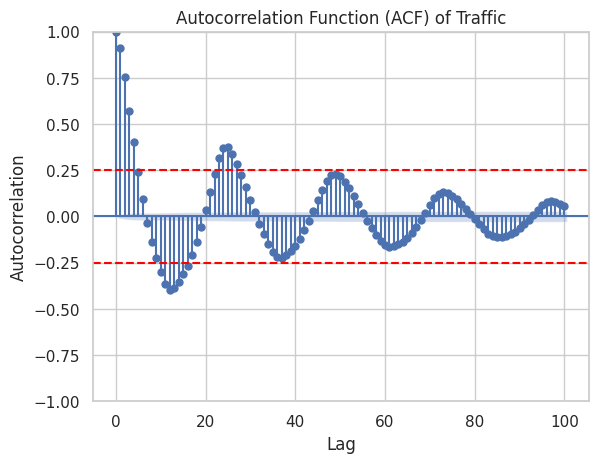

In [26]:
plt.figure(figsize=(10, 6))
plot_acf(auto_reg_data['traffic'], lags=100)
plt.axhline(y=0.25, color='red', linestyle='--', label='Threshold (0.5)')
plt.axhline(y=-0.25, color='red', linestyle='--')
plt.title('Autocorrelation Function (ACF) of Traffic')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

### **We can build a model using the last 8 lags**

### **Function to create the dataset**

In [27]:
def create_sequences(data, n_lags):
    X, y = [], []
    for i in range(len(data) - n_lags):
        X.append(data[i:(i + n_lags)])
        y.append(data[i + n_lags])
    return np.array(X), np.array(y)

In [28]:
n_lags = 8
values = auto_reg_data['traffic'].values

In [29]:
X, y = create_sequences(values, n_lags)

In [30]:
train_size = int(len(X) * 0.7)
val_size = int(len(X) * 0.2)
test_size = len(X) - train_size - val_size

In [31]:
X_train, X_val, X_test = X[:train_size], X[train_size:(train_size + val_size)], X[(train_size + val_size):]
y_train, y_val, y_test = y[:train_size], y[train_size:(train_size + val_size)], y[(train_size + val_size):]

### **Scaling the data**

In [32]:
scaler = MinMaxScaler()
X_train_reshaped = X_train.reshape(-1, n_lags)
X_val_reshaped = X_val.reshape(-1, n_lags)
X_test_reshaped = X_test.reshape(-1, n_lags)

In [33]:
X_train_scaled = scaler.fit_transform(X_train_reshaped).reshape(X_train.shape)
X_val_scaled = scaler.transform(X_val_reshaped).reshape(X_val.shape)
X_test_scaled = scaler.transform(X_test_reshaped).reshape(X_test.shape)

In [34]:
scaler_y = MinMaxScaler()
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).ravel()
y_val_scaled = scaler_y.transform(y_val.reshape(-1, 1)).ravel()
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).ravel()

In [35]:
X_train_tensor = torch.FloatTensor(X_train_scaled).reshape(-1, n_lags, 1)
y_train_tensor = torch.FloatTensor(y_train_scaled)
X_val_tensor = torch.FloatTensor(X_val_scaled).reshape(-1, n_lags, 1)
y_val_tensor = torch.FloatTensor(y_val_scaled)
X_test_tensor = torch.FloatTensor(X_test_scaled).reshape(-1, n_lags, 1)
y_test_tensor = torch.FloatTensor(y_test_scaled)

In [36]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

In [37]:
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### **Initializing all the models**

### **LSTM**

In [38]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.dropout(out[:, -1, :])
        out = self.fc(out)
        return out

### **GRU**

In [39]:
class GRUModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=2):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.gru(x)
        out = self.dropout(out[:, -1, :])
        out = self.fc(out)
        return out

### **BiDirectional LSTM**

In [40]:
class BiLSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=2):
        super(BiLSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(hidden_size * 2, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.dropout(out[:, -1, :])
        out = self.fc(out)
        return out

### **CNN-LSTM**

In [41]:
class CNNLSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=50):
        super(CNNLSTMModel, self).__init__()
        self.conv = nn.Conv1d(in_channels=input_size, out_channels=64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.lstm = nn.LSTM(64, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.conv(x)
        x = self.pool(x)
        x = x.permute(0, 2, 1)
        out, _ = self.lstm(x)
        out = self.dropout(out[:, -1, :])
        out = self.fc(out)
        return out

### **Training Function with Early Stopping**

In [42]:
def train_model(model, train_loader, val_loader, num_epochs=10, patience=5, device='cpu'):
    model.to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.2, patience=3, min_lr=1e-6)

    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    patience_counter = 0
    best_model = None

    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            output = model(X_batch).squeeze()
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * X_batch.size(0)
        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                output = model(X_batch).squeeze()
                loss = criterion(output, y_batch)
                val_loss += loss.item() * X_batch.size(0)
            val_loss /= len(val_loader.dataset)
            val_losses.append(val_loss)

        # Learning rate scheduler
        scheduler.step(val_loss)

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}")

    model.load_state_dict(best_model)
    return train_losses, val_losses

### **Training the models**

In [43]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
models = {
    'LSTM': LSTMModel(),
    'GRU': GRUModel(),
    'Bidirectional LSTM': BiLSTMModel(),
    'CNN-LSTM': CNNLSTMModel()
}
histories = {}

In [44]:
for model_name, model in models.items():
    print(f"\nTraining {model_name}...")
    train_losses, val_losses = train_model(model, train_loader, val_loader, device=device)
    histories[model_name] = {'train_loss': train_losses, 'val_loss': val_losses}


Training LSTM...
Epoch 1/10, Train Loss: 0.028542, Val Loss: 0.006004
Epoch 2/10, Train Loss: 0.010986, Val Loss: 0.005583
Epoch 3/10, Train Loss: 0.010318, Val Loss: 0.005270
Epoch 4/10, Train Loss: 0.009345, Val Loss: 0.004741
Epoch 5/10, Train Loss: 0.008398, Val Loss: 0.004246
Epoch 6/10, Train Loss: 0.007822, Val Loss: 0.003983
Epoch 7/10, Train Loss: 0.007534, Val Loss: 0.003960
Epoch 8/10, Train Loss: 0.007225, Val Loss: 0.003784
Epoch 9/10, Train Loss: 0.007046, Val Loss: 0.003745
Epoch 10/10, Train Loss: 0.006864, Val Loss: 0.003724

Training GRU...
Epoch 1/10, Train Loss: 0.019991, Val Loss: 0.006113
Epoch 2/10, Train Loss: 0.010967, Val Loss: 0.005525
Epoch 3/10, Train Loss: 0.010115, Val Loss: 0.005625
Epoch 4/10, Train Loss: 0.009489, Val Loss: 0.004780
Epoch 5/10, Train Loss: 0.008710, Val Loss: 0.004450
Epoch 6/10, Train Loss: 0.008068, Val Loss: 0.004068
Epoch 7/10, Train Loss: 0.007651, Val Loss: 0.003860
Epoch 8/10, Train Loss: 0.007269, Val Loss: 0.003739
Epoch 9/10

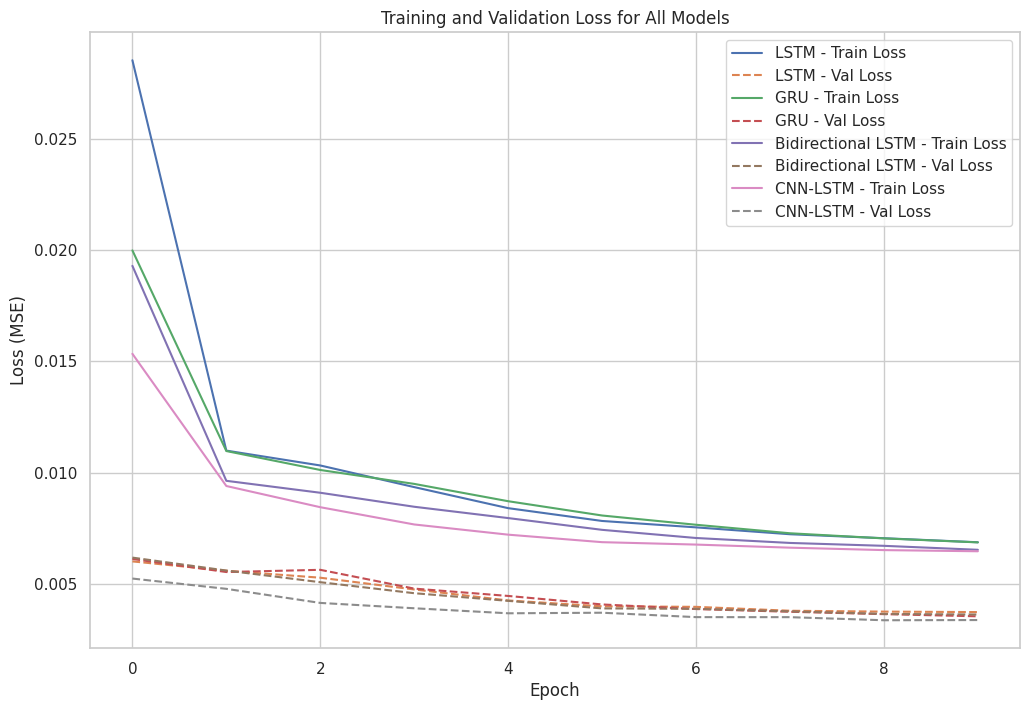

In [45]:
plt.figure(figsize=(12, 8))
for model_name, history in histories.items():
    plt.plot(history['train_loss'], label=f'{model_name} - Train Loss')
    plt.plot(history['val_loss'], linestyle='--', label=f'{model_name} - Val Loss')
plt.title('Training and Validation Loss for All Models')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

### **Test set evaluation***

In [46]:
def mean_absolute_percentage_error(y_true, y_pred, epsilon=1e-10):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / (y_true + epsilon))) * 100

In [47]:
metrics = {
    'MSE': {},
    'MAE': {},
    'RMSE': {},
    'MAPE': {}
}

In [48]:
for model_name, model in models.items():
    model.eval()
    predictions = []
    true_values = []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            output = model(X_batch).squeeze()
            predictions.append(output.cpu().numpy())
            true_values.append(y_batch.cpu().numpy())

    # Concatenate all batches
    predictions = np.concatenate(predictions)
    true_values = np.concatenate(true_values)

    # Inverse transform the predictions and true values to the original scale
    predictions_original = scaler_y.inverse_transform(predictions.reshape(-1, 1)).ravel()
    true_values_original = scaler_y.inverse_transform(true_values.reshape(-1, 1)).ravel()

    # Compute metrics
    mse = np.mean((true_values_original - predictions_original) ** 2)
    mae = np.mean(np.abs(true_values_original - predictions_original))
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(true_values_original, predictions_original)

    # Store metrics
    metrics['MSE'][model_name] = mse
    metrics['MAE'][model_name] = mae
    metrics['RMSE'][model_name] = rmse
    metrics['MAPE'][model_name] = mape

    print(f"\n{model_name} Test Metrics (Original Scale):")
    print(f"MSE: {mse:.6f}")
    print(f"MAE: {mae:.6f}")
    print(f"RMSE: {rmse:.6f}")
    print(f"MAPE: {mape:.6f}%")


LSTM Test Metrics (Original Scale):
MSE: 193744.953125
MAE: 310.617126
RMSE: 440.164703
MAPE: 15.191430%

GRU Test Metrics (Original Scale):
MSE: 181909.843750
MAE: 295.870453
RMSE: 426.508911
MAPE: 14.595896%

Bidirectional LSTM Test Metrics (Original Scale):
MSE: 188251.437500
MAE: 304.951355
RMSE: 433.879517
MAPE: 14.423376%

CNN-LSTM Test Metrics (Original Scale):
MSE: 173984.265625
MAE: 286.504822
RMSE: 417.114197
MAPE: 13.633463%


### **A dataframe for metrics**

In [55]:
metrics_df = pd.DataFrame(metrics).T  # Transpose to have metrics as rows and models as columns
metrics_df = metrics_df[['LSTM', 'GRU', 'Bidirectional LSTM', 'CNN-LSTM']]  # Ensure consistent ordering
print("\nTest Metrics Table:")
print(metrics_df.round(6))


Test Metrics Table:
               LSTM            GRU  Bidirectional LSTM       CNN-LSTM
MSE   193744.937500  181909.843750       188251.437500  173984.265625
MAE      310.617126     295.870453          304.951355     286.504822
RMSE     440.164703     426.508911          433.879517     417.114197
MAPE      15.191430      14.595896           14.423376      13.633463


### **Plotting all metrics**

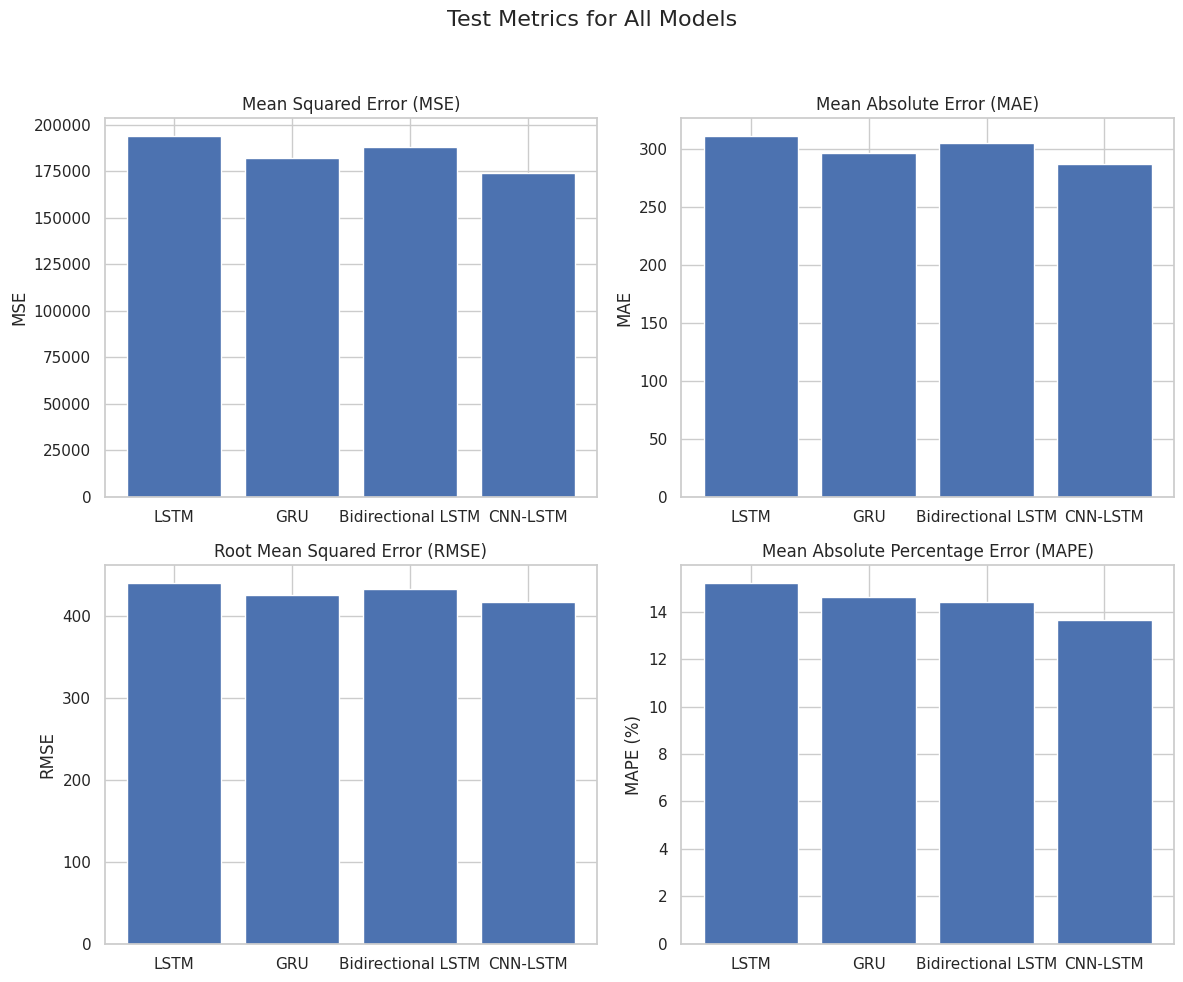

In [56]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Test Metrics for All Models', fontsize=16)

axes[0, 0].bar(metrics['MSE'].keys(), metrics['MSE'].values())
axes[0, 0].set_title('Mean Squared Error (MSE)')
axes[0, 0].set_ylabel('MSE')

# MAE
axes[0, 1].bar(metrics['MAE'].keys(), metrics['MAE'].values())
axes[0, 1].set_title('Mean Absolute Error (MAE)')
axes[0, 1].set_ylabel('MAE')

# RMSE
axes[1, 0].bar(metrics['RMSE'].keys(), metrics['RMSE'].values())
axes[1, 0].set_title('Root Mean Squared Error (RMSE)')
axes[1, 0].set_ylabel('RMSE')

# MAPE
axes[1, 1].bar(metrics['MAPE'].keys(), metrics['MAPE'].values())
axes[1, 1].set_title('Mean Absolute Percentage Error (MAPE)')
axes[1, 1].set_ylabel('MAPE (%)')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()